In [1]:
import os
import numpy as np
import string
import pickle
from tqdm.notebook import tqdm

from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


2025-06-21 14:39:57.242760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750516797.267055  291566 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750516797.275052  291566 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR='/kaggle/input/flickr8k'
WORKING_DIR='/kaggle/working/'

In [3]:
# Load EfficientNetB3 model and add GlobalAveragePooling to get 1D vector (1536,)
base_model = EfficientNetB3(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)

I0000 00:00:1750516801.857295  291566 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
#Feature extraction
features = {}
directory = os.path.join(BASE_DIR, 'Images')  # ✅ Make sure BASE_DIR is defined correctly

for img_name in tqdm(os.listdir(directory)):
    if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue  # skip non-image files

    img_path = os.path.join(directory, img_name)

    # Load and preprocess the image
    image = load_img(img_path, target_size=(300, 300))  # EfficientNetB3 expects 300x300
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    # Extract features (output shape: (1, 1536))
    feature = model.predict(image, verbose=0)

    # Squeeze to remove batch dimension → shape: (1536,)
    feature = np.squeeze(feature)

    # Get image ID and store
    image_id = img_name.split('.')[0]
    features[image_id] = feature

print("✅ Feature extraction complete.")

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1750516809.690763  291612 service.cc:148] XLA service 0x780e3406edf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750516809.690794  291612 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750516810.698188  291612 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750516815.314949  291612 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


✅ Feature extraction complete.


In [5]:
print(next(iter(features.values())).shape)  # Should be (1536,)

(1536,)


In [6]:
# Save extracted features to a pickle file
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb') as f:
    pickle.dump(features, f)

In [7]:
# Load features from pickle file
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
mapping = {}

# Parse the captions document line by line
for line in tqdm(captions_doc.strip().split('\n')):
    # Skip empty lines
    if not line.strip():
        continue

    # Split line by comma
    tokens = line.strip().split(',')

    # Skip if line has fewer than 2 parts (image name + caption)
    if len(tokens) < 2:
        continue

    # Extract image ID and caption
    img_id = tokens[0].strip()
    caption = " ".join(tokens[1:]).strip()

    # Remove image extension (e.g., .jpg)
    image_id = img_id.split('.')[0]

    # Initialize list if not already present
    if image_id not in mapping:
        mapping[image_id] = []

    # Add caption to the list
    mapping[image_id].append(caption)

print("✅ Caption mapping created successfully!")
print(f"🖼️ Number of images with captions: {len(mapping)}")


  0%|          | 0/40455 [00:00<?, ?it/s]

✅ Caption mapping created successfully!
🖼️ Number of images with captions: 8091


In [10]:
len(mapping)

8091

In [11]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]

            # Convert to lowercase
            caption = caption.lower()

            # Remove special characters and digits using regex
            caption = re.sub(r'[^a-z\s]', '', caption)

            # Remove extra spaces
            caption = re.sub(r'\s+', ' ', caption).strip()

            # Remove short words and add start/end tokens
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'

            # ✅ Update the cleaned caption in-place
            captions[i] = caption
           


In [12]:
clean(mapping)

In [13]:
# before preprocess the text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
# after preprocess the txt
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Create and fit tokenizer on all captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Vocabulary size (add +1 for padding token or 0 index)
vocab_size = len(tokenizer.word_index) + 1

print(f'Vocab Size: {vocab_size}')


Vocab Size: 8768


In [19]:

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [20]:
# Get the maximum length of any caption
max_length = max(len(caption.split()) for caption in all_captions)
print(f'Max Caption Length: {max_length}')

Max Caption Length: 34


In [21]:
# Get all image IDs
image_ids = list(mapping.keys())

# Split 90% for training, 10% for testing
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

print(f"Training Samples: {len(train)}")
print(f"Testing Samples: {len(test)}")

Training Samples: 7281
Testing Samples: 810


In [22]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0

    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

                    # One-hot encode output word
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # EfficientNet features (flatten or pooled already)
                    image_feature = features[key]  # assume 1D (flattened) shape: (153600,) or similar

                    X1.append(image_feature)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0


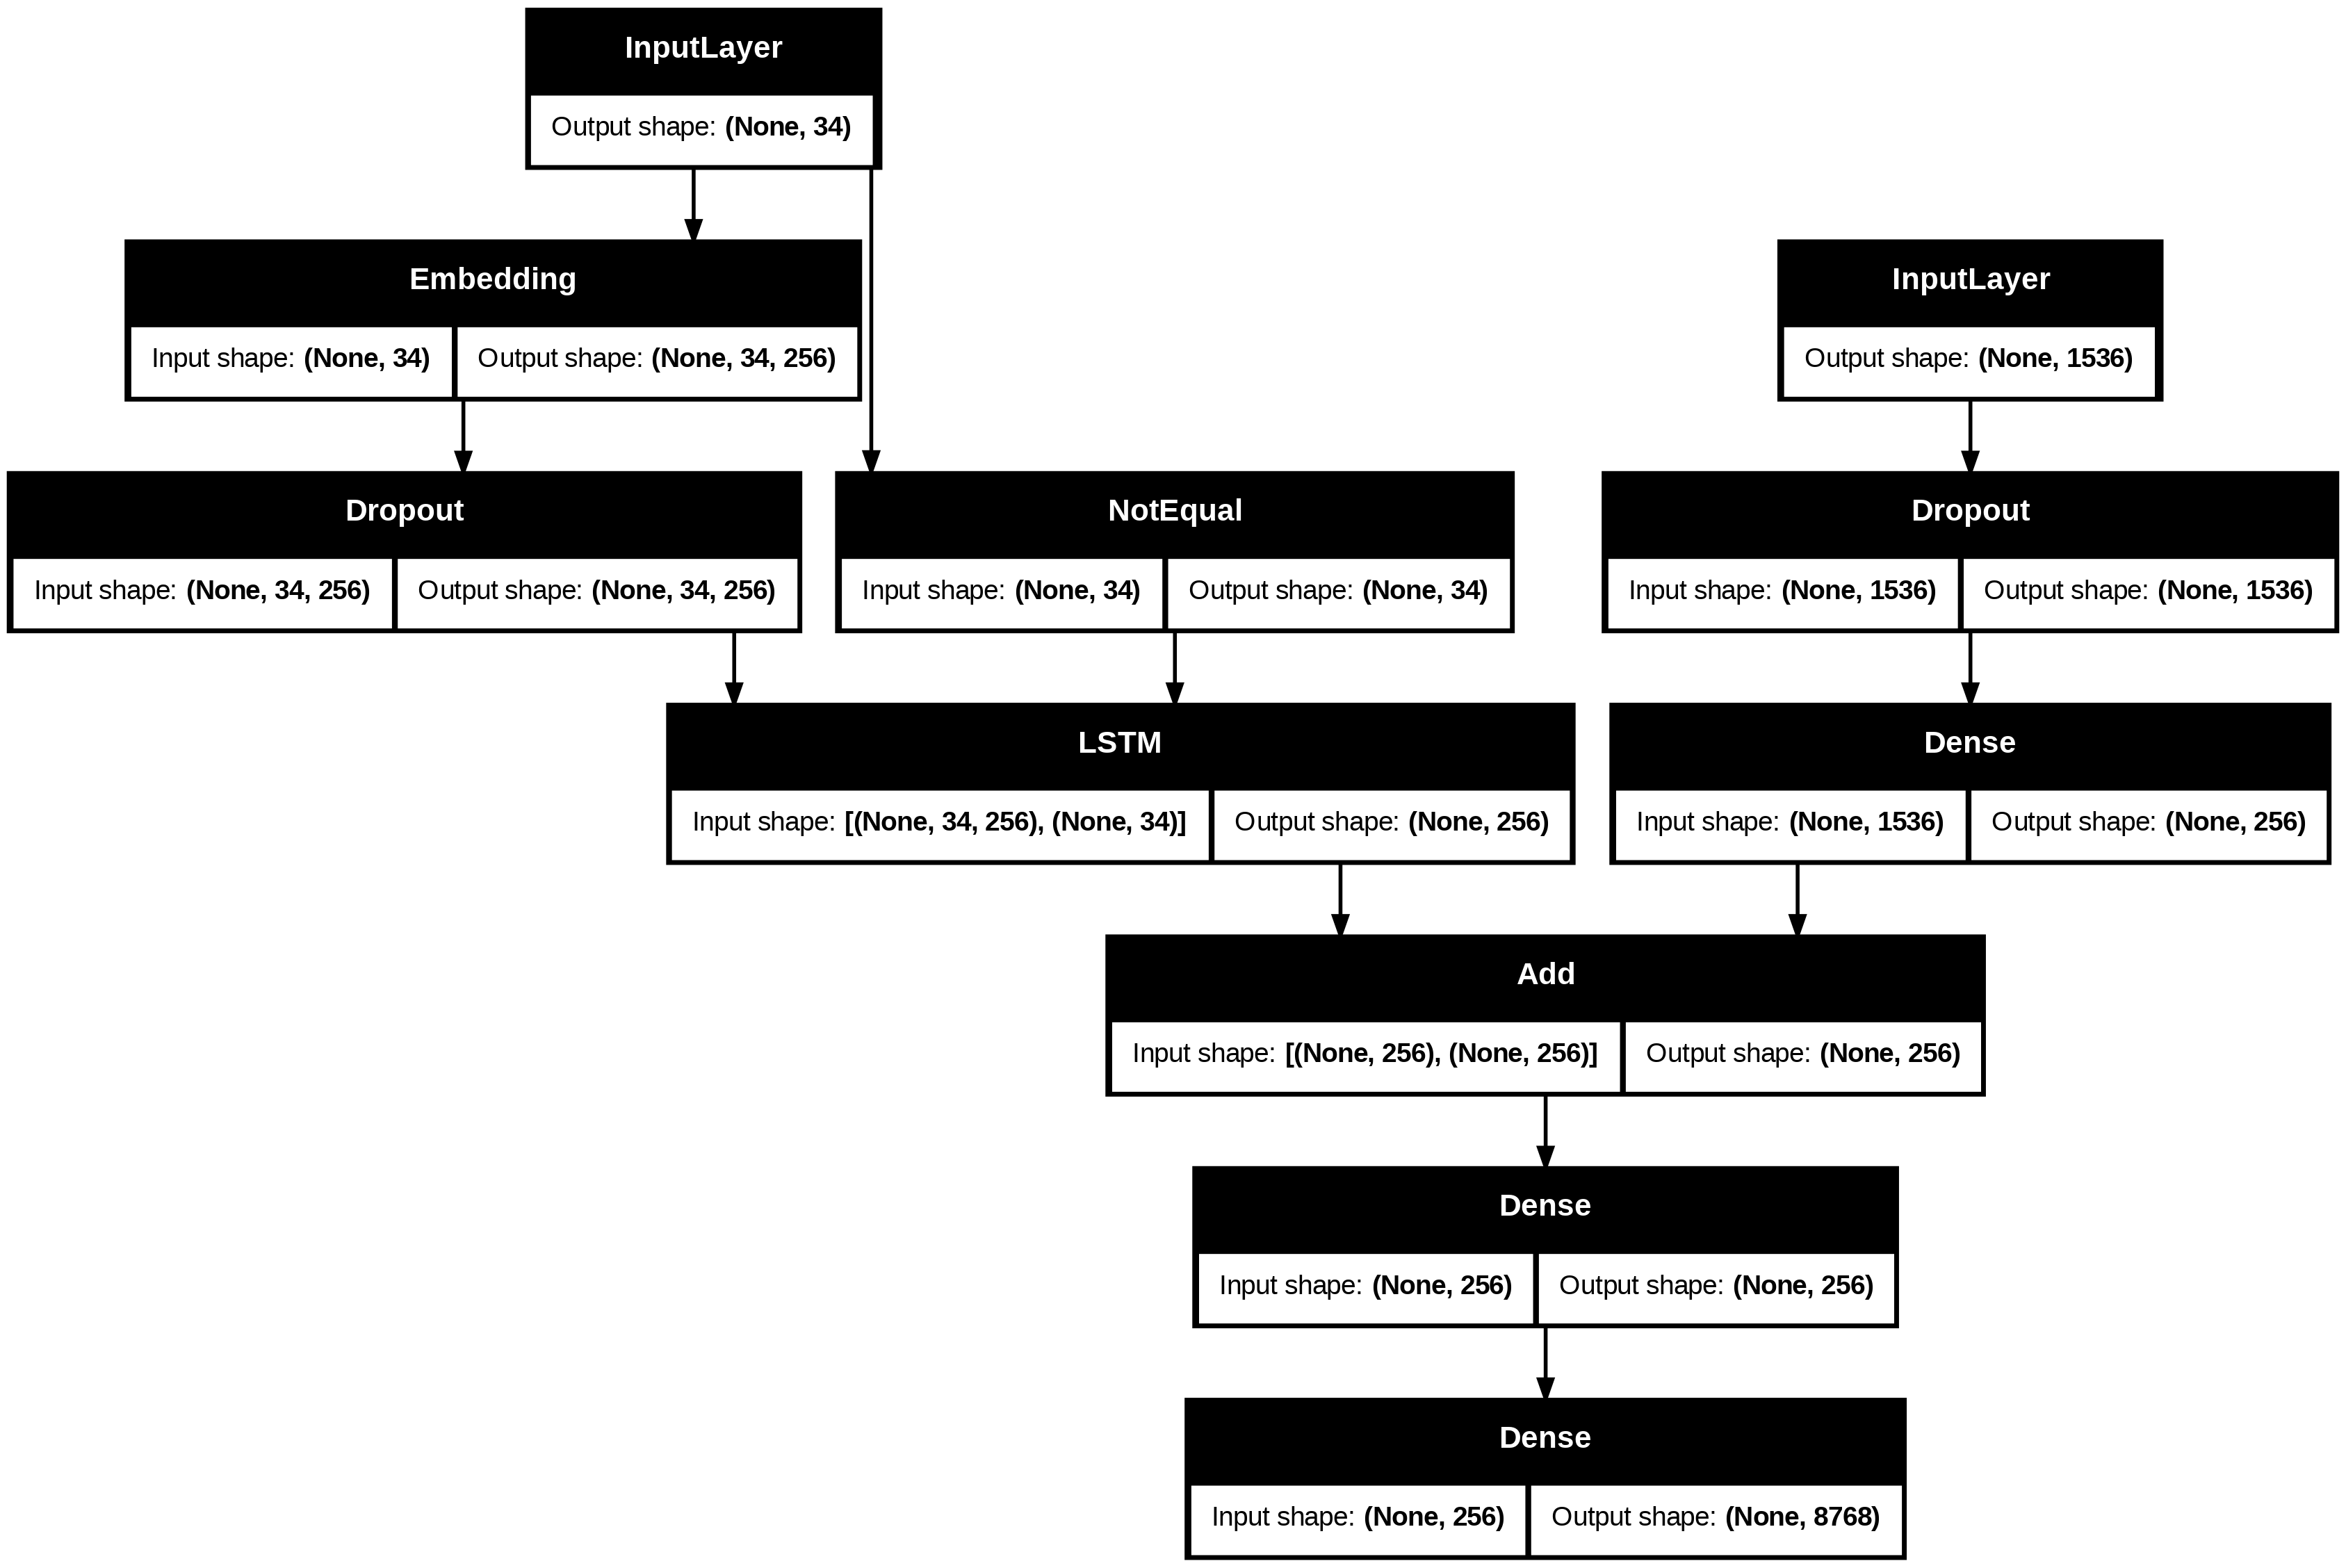

In [49]:
from tensorflow.keras.utils import plot_model

# EfficientNet feature size after GlobalAveragePooling2D
efficientnet_feature_dim = 1536  # Or match your actual feature shape

# Image feature layers
inputs1 = Input(shape=(efficientnet_feature_dim,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model (merge image + text features)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Final model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

In [50]:
feature = np.squeeze(feature)
print(f"Squeezed feature shape: {feature.shape}")

Squeezed feature shape: (1536,)


In [63]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

print("Model training complete!")

227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - loss: 2.3170
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 226ms/step - loss: 2.2493
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 225ms/step - loss: 2.1993
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - loss: 2.1489
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step - loss: 2.1046
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step - loss: 2.0654
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 225ms/step - loss: 2.0283
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 225ms/step - loss: 1.9970
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - loss: 1.9629
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step - loss: 1.9335
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step - loss: 1.9060
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step - loss: 1.8809
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 225ms/step - loss: 1.8582
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 225ms/step - loss: 1.8352
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 225ms/step - loss: 1.8165
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step - loss: 1.7965
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step - loss: 1.77

In [73]:
os.remove(os.path.join('best_caption_model.h5'))

In [74]:
model.save("image_caption_model.keras")
print("Model saved!")

Model saved!


In [65]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [67]:
def predict_caption(model, image_feature, tokenizer, max_length):
   
    in_text = 'startseq'

    # Ensure image is shaped correctly for prediction
    if image_feature.ndim == 1:
        image_feature = np.expand_dims(image_feature, axis=0)  # (1, 1536)

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        yhat = model.predict([image_feature, sequence], verbose=0)
        yhat = np.argmax(yhat)

        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break

        in_text += ' ' + word
        if word == 'endseq':
            break

    # Remove 'startseq' and 'endseq' before returning
    final_caption = in_text.split()
    final_caption = final_caption[1:-1] if final_caption[-1] == 'endseq' else final_caption[1:]
    return ' '.join(final_caption)


In [68]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

actual, predicted = [], []

for key in tqdm(test):
    # Get actual cleaned captions
    actual_captions = [caption.split() for caption in mapping[key]]

    # Generate predicted caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    y_pred = y_pred.split()

    # Store for BLEU evaluation
    actual.append(actual_captions)   # list of references
    predicted.append(y_pred)         # single predicted sequence

# Calculate BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

100%|██████████| 810/810 [10:59<00:00,  1.23it/s]


BLEU-1: 0.432394
BLEU-2: 0.257634
BLEU-3: 0.178229
BLEU-4: 0.080785


In [70]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):

    # Extract image ID and load image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    # Show actual captions
    print('---------------------Actual---------------------')
    if image_id in mapping:
        for caption in mapping[image_id]:
            print(caption)
    else:
        print("No actual captions found.")

    # Generate predicted caption
    if image_id in features:
        y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
        print('--------------------Predicted--------------------')
        print(y_pred)
    else:
        print("No features found for this image.")

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()


---------------------Actual---------------------
startseq dog shakes its head near the shore red ball next to it endseq
startseq white dog shakes on the edge of beach with an orange ball endseq
startseq dog with orange ball at feet stands on shore shaking off water endseq
startseq white dog playing with red ball on the shore near the water endseq
startseq white dog with brown ears standing near water with head turned to one side endseq
--------------------Predicted--------------------
white dog with brown ears is standing on the beach with its tongue sticking out


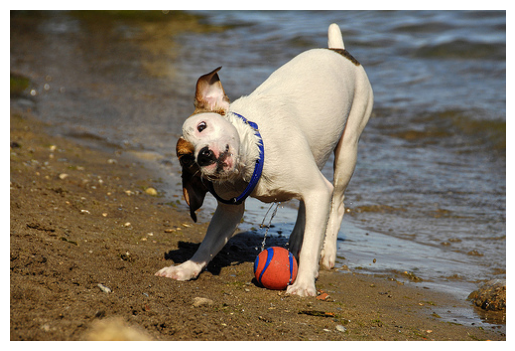

In [71]:
generate_caption("1012212859_01547e3f17.jpg")

---------------------Actual---------------------
startseq black and white dog jumping in the air to get toy endseq
startseq black and white dog jumps up towards yellow toy endseq
startseq dog leaps to catch ball in field endseq
startseq white dog is trying to catch ball in midair over grassy field endseq
startseq the white dog is playing in green field with yellow toy endseq
--------------------Predicted--------------------
white dog with green toy in its mouth is jumping over red cloth in field


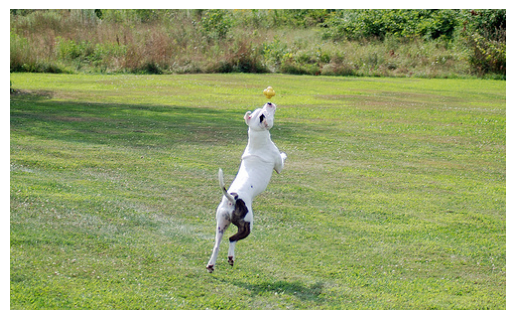

In [72]:
generate_caption("1020651753_06077ec457.jpg")